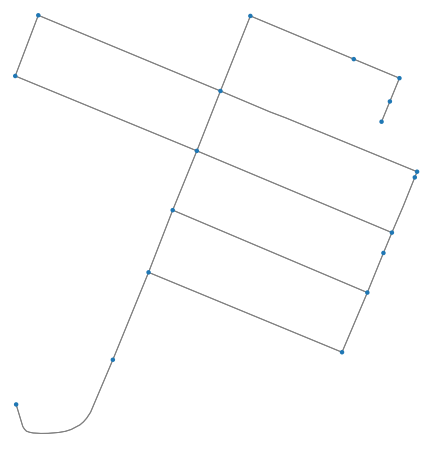

Locations added to the dataframe
Latitudes and longitudes appended
Starting with distance calculations...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/19de61c886424bd28813a7082344ff9f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/19de61c886424bd28813a7082344ff9f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 349 COLUMNS
At line 3014 RHS
At line 3359 BOUNDS
At line 3720 ENDATA
Problem MODEL has 344 rows, 360 columns and 1602 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1706.87 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 306 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 306 strength

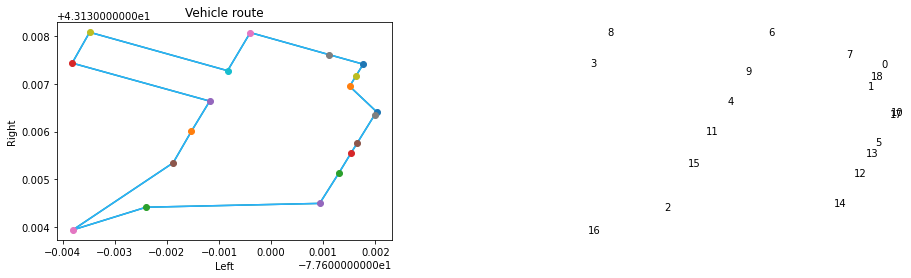

OUR MODEL ROUTES:
[[(11, 4), (4, 3), (3, 8), (8, 9), (9, 6), (6, 7), (7, 0), (0, 18), (18, 1), (1, 10), (10, 17), (17, 5), (5, 13), (13, 12), (12, 14), (14, 2), (2, 16), (16, 15), (15, 11)]]
ROUTES FROM OR-TOOLS
Route for vehicle 0:
 11 ->  14 ->  12 ->  13 ->  5 ->  17 ->  10 ->  1 ->  18 ->  0 ->  7 ->  6 -> 11

Route for vehicle 1:
 11 ->  15 ->  16 ->  2 ->  3 ->  8 ->  9 ->  4 -> 11



In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Sample bounding box in Rochester, NY - Plymouth exchange - Mayors Heights
north, south, east, west = 43.133656,43.138291,-77.603903,-77.597766

# create a network from the above bounded box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='gray', node_size=20)


#Add locations to dataframe
Locations = []
for i in G.nodes:
    Locations.append(i)

roc_data = pd.DataFrame(Locations)
roc_data.rename(columns = {0:'Locations'}, inplace = True)
print("Locations added to the dataframe")   

#Appending lats and longitudes
latitude = []
longitude = []
for i in Locations:
    latitude.append(G.nodes[i].get('y'))
    longitude.append(G.nodes[i].get('x'))
print("Latitudes and longitudes appended")       
roc_data['Latitude'] = latitude
roc_data['Longitude'] = longitude
roc_df = roc_data
roc_df = roc_df.drop(['Locations'],axis=1)
roc_df.rename(columns = {'Latitude':'Left'}, inplace = True)
roc_df.rename(columns = {'Longitude':'Right'}, inplace = True)

print("Starting with distance calculations...")   

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in roc_df.index:
    list1 = []
    for i in roc_df.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{roc_df.loc[j, "Right"]},{roc_df.loc[j, "Left"]};{roc_df.loc[i, "Right"]},{roc_df.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = roc_df
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index


locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)



#***************************************************************************************************************************************************************************************************

#                                     LP MODEL
#***************************************************************************************************************************************************************************************************
## V:the number vehicles/people deployed
V = 1
## prob: initializing the problem
prob=LpProblem("vehicle", LpMinimize)

#indicates if location i is connected to location j along route 
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
#elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
#cost: This stores the result of calculations for distances
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost


#constraints
for v in df.ID:
    cap = 1 if v != 11 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    
#subtour elimination
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != 11 and j!= 11) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
prob.solve()

#feasible_edges: This stores values of edges
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
#@get_next_loc: to get the next edge
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges


#routes: This stores information regarding paths  
routes = get_next_loc(11)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=11:
        r.append(get_next_loc(r[-1][1])[-1])
        
        
#outline the routes
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
        
#outline the routes
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Left')
plt.ylabel('Right')
plt.show()
   
print("OUR MODEL ROUTES:")
print(routes)

#*************************************************************************************************************************************************************************************************
#                                         OR TOOLS
#*************************************************************************************************************************************************************************************************

#@create_data_model : stores the number of vehicles to be deployed and source to start at (depot)
#for the problem to be evaluated
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 2

    data['depot'] = 11
    return data

#@print_solution: Prints the solution 
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    print("ROUTES FROM OR-TOOLS")
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main-Solve the CVRP problem.
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()



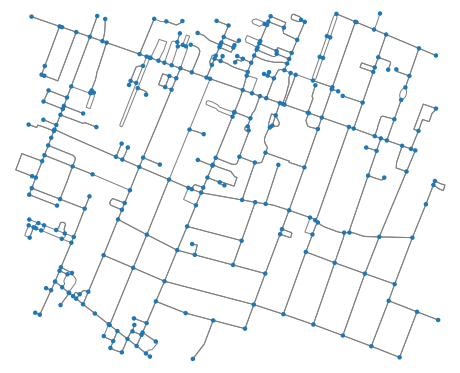

Locations added to the dataframe
Latitudes and longitudes appended
Starting with distance calculations...


KeyboardInterrupt: 

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Sample bounding box in Rochester, NY -- Goodwin Park along East Ave
north, south, east, west = 43.151145,43.155058,-77.595792,-77.590728


# create a network from the above bounded box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='gray', node_size=20)


#Add locations to dataframe
Locations = []
for i in G.nodes:
    Locations.append(i)

roc_data = pd.DataFrame(Locations)
roc_data.rename(columns = {0:'Locations'}, inplace = True)
print("Locations added to the dataframe")   

#Appending lats and longitudes
latitude = []
longitude = []
for i in Locations:
    latitude.append(G.nodes[i].get('y'))
    longitude.append(G.nodes[i].get('x'))
print("Latitudes and longitudes appended")       
roc_data['Latitude'] = latitude
roc_data['Longitude'] = longitude
roc_df = roc_data
roc_df = roc_df.drop(['Locations'],axis=1)
roc_df.rename(columns = {'Latitude':'Left'}, inplace = True)
roc_df.rename(columns = {'Longitude':'Right'}, inplace = True)

print("Starting with distance calculations...")   

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in roc_df.index:
    list1 = []
    for i in roc_df.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{roc_df.loc[j, "Right"]},{roc_df.loc[j, "Left"]};{roc_df.loc[i, "Right"]},{roc_df.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = roc_df
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index


locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)



#***************************************************************************************************************************************************************************************************

#                                     LP MODEL
#***************************************************************************************************************************************************************************************************
## V:the number vehicles/people deployed
V = 1
## prob: initializing the problem
prob=LpProblem("vehicle", LpMinimize)

#indicates if location i is connected to location j along route 
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
#elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
#cost: This stores the result of calculations for distances
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost


#constraints
for v in df.ID:
    cap = 1 if v != 11 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    
#subtour elimination
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != 11 and j!= 11) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
prob.solve()

#feasible_edges: This stores values of edges
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
#@get_next_loc: to get the next edge
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges


#routes: This stores information regarding paths  
routes = get_next_loc(11)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=11:
        r.append(get_next_loc(r[-1][1])[-1])
        
        
#outline the routes
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
        
#outline the routes
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Left')
plt.ylabel('Right')
plt.show()
   
print("OUR MODEL ROUTES:")
print(routes)

#*************************************************************************************************************************************************************************************************
#                                         OR TOOLS
#*************************************************************************************************************************************************************************************************

#@create_data_model : stores the number of vehicles to be deployed and source to start at (depot)
#for the problem to be evaluated
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 2

    data['depot'] = 11
    return data

#@print_solution: Prints the solution 
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    print("ROUTES FROM OR-TOOLS")
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main-Solve the CVRP problem.
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()


